In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
DATAPATH2 = configs["DATAPATH2"]
ROOTPATH2 = configs["ROOTPATH2"]
# OUTPATH = "../../output/results-summary-062624/"
OUTPATH = "../../output/results-summary-081224/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


## Load data (view, subscribe, comment + survey)

In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id"]].dropna()
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

In [3]:
pol_df = pd.read_csv(DATAPATH + "survey/pol_survey_cleaned_NEW_INCLUDEALL.csv").rename(columns={"user_id":"respondent_id"})
pol_df.head()
print(pol_df.columns)

# get new weights [new!]
pol_df.drop(columns=["weight"], inplace=True)
new_weights = pd.read_spss(DATAPATH + "survey/TK_DataDonation_eng.sav")[["respondent_id","weight"]]
new_weights["respondent_id"] = new_weights["respondent_id"].map(lambda x: int(x))
pol_df = pol_df.merge(new_weights, on="respondent_id", how="left")
len(pol_df)

Index(['respondent_id', 'weight', 'gender', 'birth_year', 'education',
       'fb_freq', 'ig_freq', 'tw_freq', 'yt_freq', 'lk_freq', 'tt_freq',
       'sp_freq', 'sns_view_politics', 'sns_view_politics_friends',
       'sns_view_politics_disagree', 'sns_view_politics_progov',
       'sns_view_politics_antigov', 'seek_politics_tv', 'seek_politics_radio',
       'seek_politics_newpp', 'seek_politics_sites', 'seek_politics_sns',
       'seek_politics_convo', 'talk_politics_frfa', 'align_politics_frfa',
       'interest_politics', 'vote_party_2022', 'would_go_vote_sunday',
       'would_vote_party_sunday', 'know_sppt_fdsz', 'know_sppt_mszp',
       'know_sppt_jbbk', 'know_sppt_lmp', 'know_sppt_dk', 'know_sppt_mtum',
       'know_sppt_mhzk', 'know_relate_fdsz', 'know_relate_mszp',
       'know_relate_jbbk', 'know_relate_lmp', 'know_relate_dk',
       'know_relate_mtum', 'know_relate_mhzk', 'feel_thm_fdsz',
       'feel_thm_mszp', 'feel_thm_jbbk', 'feel_thm_lmp', 'feel_thm_dk',
       'feel_

758

## Load labels

In [4]:
# load all political channel 
cols = ["channel_id", "upload_id", "topics_str"]
# channel_info = pd.read_csv(DATAPATH2 + "clean/channel-info.csv")[cols].dropna(subset="topics_str")
channel_info = pd.read_pickle(DATAPATH2 + "clean/channel-info-042624.pkl")[cols].dropna(subset="topics_str")

# get a list of political videos and channels that have uploaded political videos
pol_videos = pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["video_id"].tolist()
pol_videos_ch = set(pd.read_pickle(DATAPATH + "youtube/youtube_video_meta_politics.pkl")["channel_id"].tolist())

CHANNEL_CATG = "Politics"
pol_channels = channel_info[channel_info["topics_str"].str.contains(CHANNEL_CATG)]["channel_id"].tolist()
pol_channels = set(pol_channels).union(pol_videos_ch)
print("# of political channels:", len(set(pol_channels)))  # 11346

# of political channels: 11346


In [5]:
channel_labels_hu = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_hu

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_hu[channel_labels_hu[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"] = {"before":-1, "after":1} 

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


## Extract user groups

In [6]:
pol_view = view_all[view_all["channel_id"].isin(pol_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(pol_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(pol_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(pol_channels)].copy()

In [7]:
hupol_channels = CHANNEL_LABEL_MAP.keys()
hupol_view = view_all[view_all["channel_id"].isin(hupol_channels)].copy()
hupol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment = comment_all[comment_all["channel_id"].isin(hupol_channels)].copy()
hupol_comment_public = comment_public[comment_public["channel_id"].isin(hupol_channels)].copy()

uall = set(pol_df["respondent_id"].tolist())
uytb = set(view_all["respondent_id"].tolist()).union(set(subscribe_all["respondent_id"].tolist())).union(set(comment_all["respondent_id"].tolist()))
upol = set(pol_view["respondent_id"].tolist()).union(set(pol_subscribe["respondent_id"].tolist())).union(set(pol_comment["respondent_id"].tolist()))
uhup = set(hupol_view["respondent_id"].tolist()).union(set(hupol_subscribe["respondent_id"].tolist())).union(set(hupol_comment["respondent_id"].tolist()))

uv = set(hupol_view["respondent_id"].tolist())
us = set(hupol_subscribe["respondent_id"].tolist())
uc = set(hupol_comment["respondent_id"].tolist())

UGROUPS = [uall, uytb, upol, uhup, uv, us, uc]
UGROUPS_LAB = ["ALL", "YTB", "POL", "POL-HU", "VIEW", "SBSC", "CMNT"]

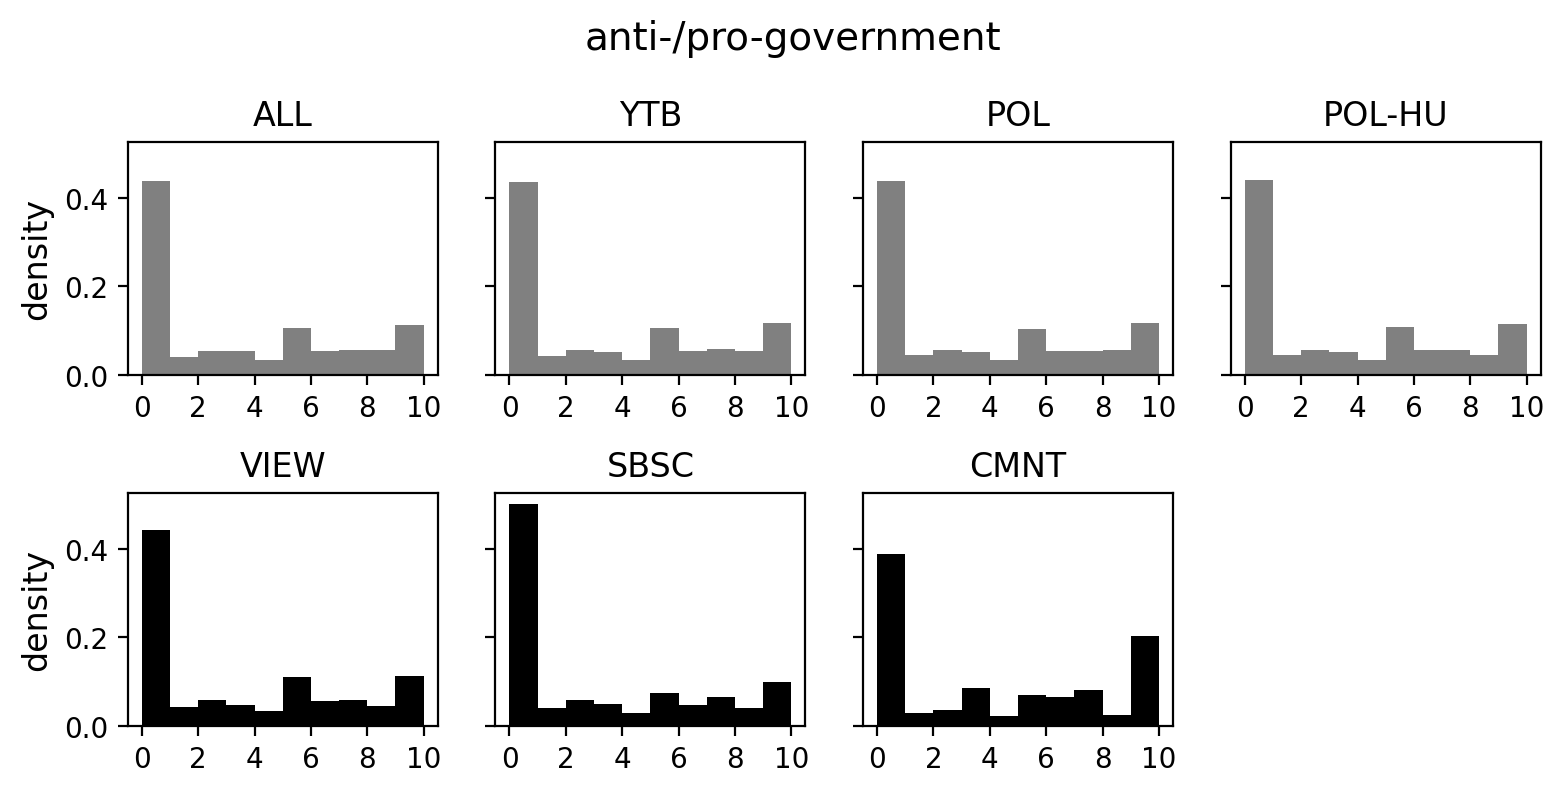

In [8]:
fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(8,4), sharey=True)
axes = [x for ls in axes for x in ls]

varname = "feel_thm_fdsz"
varname_display = "anti-/pro-government"
# varname = "lftRght"
# varname_display = "left/right"

for i,(ax,u,lab) in enumerate(zip(axes, UGROUPS, UGROUPS_LAB)):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    if i <= 3: 
        ax.hist(sub_df[varname], density=True, bins=10, color="grey", weights=sub_df["weight"])
    else:
        ax.hist(sub_df[varname], density=True, bins=10, color="black", weights=sub_df["weight"])
    ax.set_title(lab, fontsize=12)
    # ax.set_xticks([*range(1,8,2)], [*range(1,8,2)])
    ax.set_xticks([*range(0,12,2)], [*range(0,12,2)])
for i in [0,4]:
    axes[i].set_ylabel("density", fontsize=12)
# axes[4].set_xlabel(varname_display, fontsize=12)
plt.suptitle(varname_display, fontsize=14)
plt.tight_layout()
axes[-1].set_visible(False)
# plt.savefig(OUTPATH + f"distribution-user-{varname}-diff-pol-activities-weighted.pdf", dpi=300, bbox_inches="tight")

In [9]:
from scipy.stats import kurtosis

def compute_kurtosis(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return kurtosis(data)

def compute_variance(data):
    data = [d for d in data if str(d) != "nan"]
    if len(data) == 0:
        return np.NaN
    else:
        return np.var(data)

In [10]:
# # create a sample
# nruns = 200
# bp_data_flth = {}
# bp_data_lrsc = {}
# for u,lab in zip(UGROUPS, UGROUPS_LAB):
#     sub_df = pol_df[pol_df["respondent_id"].isin(u)]
#     kts_ls_flth = []
#     kts_ls_lrsc = []
#     for r in range(nruns):
#         sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
#         kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
#         kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
#     bp_data_flth[lab] = kts_ls_flth
#     bp_data_lrsc[lab] = kts_ls_lrsc

# fig,axes = plt.subplots(ncols=2, figsize=(8.6,3))
# for i, (bp_data, title) in enumerate(zip([bp_data_flth, bp_data_lrsc], ["feel_thm_fdsz", "lftRght"])):
#     # axes[i].boxplot(bp_data, sym="+")
#     bp_data = bp_data.values()
#     vp = axes[i].violinplot(bp_data, showmedians=True, )
#     axes[i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB)
#     axes[i].set_title(title, fontsize=12)

#     for pc, color in zip(vp["bodies"], ["grey"]*len(vp["bodies"])):
#         pc.set_facecolor(color)

#     for item in ["cmedians", "cbars", "cmaxes", "cmins"]:
#         vp[item].set_colors("grey")

# axes[0].set_ylabel("kurtosis", fontsize=12)
# axes[0].set_ylim(-2, 0.3)
# axes[1].set_ylim(-1.8, 0.5)
# # axes[1].set_ylim(-1.55, 0.4)
# plt.tight_layout()
# plt.savefig(OUTPATH + "kurtosis_violinplot.pdf", dpi=300, bbox_inches="tight")

In [11]:
# # perform ks test to show the differences are statistically significant 

# from scipy.stats import entropy, ks_2samp, mannwhitneyu

# groups = [
#     ("VIEW", "CMNT"),
#     ("SBSC", "CMNT"), 
#     ("VIEW", "SBSC"),
# ]

# for g1, g2 in groups:
#     # sample1 = bp_data_flth[g1]
#     # sample2 = bp_data_flth[g2]
#     sample1 = bp_data_lrsc[g1]
#     sample2 = bp_data_lrsc[g2]
#     d, p = ks_2samp(sample1, sample2, alternative="less")
#     print(g1, g2, round(d,5), round(p,4))

In [12]:
# # create a sample
# nruns = 200
# bp_data_flth = {}
# bp_data_lrsc = {}
# for u,lab in zip(UGROUPS, UGROUPS_LAB):
#     sub_df = pol_df[pol_df["respondent_id"].isin(u)]
#     var_ls_flth = []
#     var_ls_lrsc = []
#     for r in range(nruns):
#         sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
#         var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
#         var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
#     bp_data_flth[lab] = var_ls_flth
#     bp_data_lrsc[lab] = var_ls_lrsc

# fig,axes = plt.subplots(ncols=2, figsize=(8.6,3))
# for i, (bp_data, title) in enumerate(zip([bp_data_flth, bp_data_lrsc], ["feel_thm_fdsz", "lftRght"])):
#     # axes[i].boxplot(bp_data, sym="+")
#     bp_data = bp_data.values()
#     vp = axes[i].violinplot(bp_data, showmedians=True, )
#     axes[i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB)
#     axes[i].set_title(title, fontsize=12)

#     for pc, color in zip(vp["bodies"], ["grey"]*len(vp["bodies"])):
#         pc.set_facecolor(color)

#     for item in ["cmedians", "cbars", "cmaxes", "cmins"]:
#         vp[item].set_colors("grey")

# axes[0].set_ylim(8.4, 19.4)
# # axes[1].set_ylim(-1.8, 0.5)

# axes[0].set_ylabel("variance", fontsize=12)
# plt.tight_layout()
# plt.savefig(OUTPATH + "variance_violinplot.pdf", dpi=300, bbox_inches="tight")

In [13]:
# # perform ks test to show the differences are statistically significant 

# from scipy.stats import entropy, ks_2samp, mannwhitneyu

# groups = [
#     ("VIEW", "COMM"),
#     ("SBSC", "COMM"), 
#     ("VIEW", "SBSC"),
# ]

# for g1, g2 in groups:
#     # sample1 = bp_data_flth[g1]
#     # sample2 = bp_data_flth[g2]
#     sample1 = bp_data_lrsc[g1]
#     sample2 = bp_data_lrsc[g2]
#     d, p = ks_2samp(sample1, sample2, alternative="greater")
#     print(g1, g2, round(d,5), round(p,4))

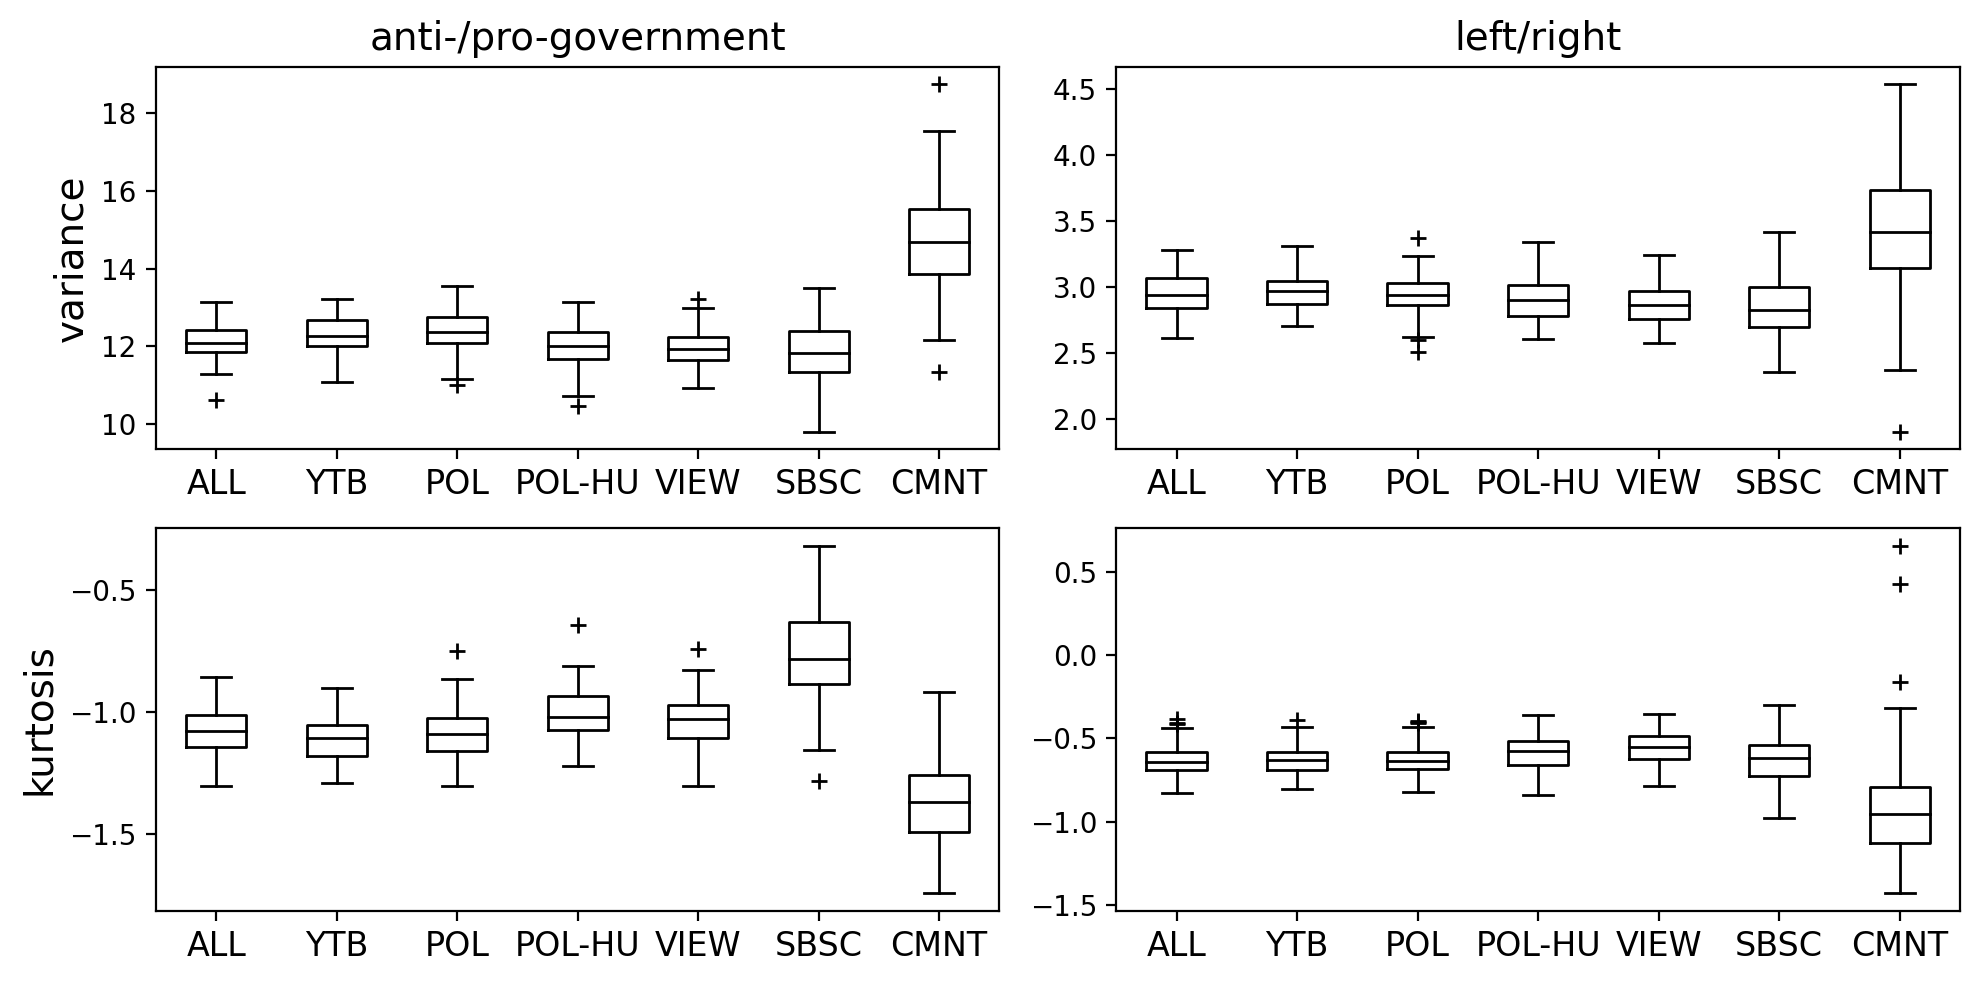

In [14]:
# merge two figures
nruns = 100
bp_data_flth_var = {}
bp_data_lrsc_var = {}
bp_data_flth_kts = {}
bp_data_lrsc_kts = {}
for u,lab in zip(UGROUPS, UGROUPS_LAB):
    sub_df = pol_df[pol_df["respondent_id"].isin(u)]
    var_ls_flth = []
    var_ls_lrsc = []
    kts_ls_flth = []
    kts_ls_lrsc = []
    for r in range(nruns):
        sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
        var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
        var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
        kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
        kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
    bp_data_flth_var[lab] = var_ls_flth
    bp_data_lrsc_var[lab] = var_ls_lrsc
    bp_data_flth_kts[lab] = kts_ls_flth
    bp_data_lrsc_kts[lab] = kts_ls_lrsc

fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
for i, (bp_data, title) in enumerate(zip([bp_data_flth_var, bp_data_lrsc_var], ["feel_thm_fdsz", "lftRght"])):
    bp_data = bp_data.values()
    bp = axes[0,i].boxplot(bp_data, sym="+")
    axes[0,i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB, fontsize=12)
    # axes[0,i].set_title(title, fontsize=14)
    axes[0,0].set_ylabel("variance", fontsize=14)

    # for pc, color in zip(vp["bodies"], ["grey"]*len(vp["bodies"])):
    #     pc.set_facecolor(color)

    # for item in ["cmedians", "cbars", "cmaxes", "cmins"]:
    #     vp[item].set_colors("grey")

    for median in bp["medians"]:
        median.set_color("black")

for i, (bp_data, title) in enumerate(zip([bp_data_flth_kts, bp_data_lrsc_kts], ["feel_thm_fdsz", "lftRght"])):
    bp_data = bp_data.values()
    # vp = axes[1,i].violinplot(bp_data, showmedians=True, )
    bp = axes[1,i].boxplot(bp_data, sym="+")
    axes[1,i].set_xticks(range(1,len(UGROUPS_LAB)+1), UGROUPS_LAB, fontsize=12)
    # axes[1,i].set_title(title, fontsize=12)
    axes[1,0].set_ylabel("kurtosis", fontsize=14)

    # for pc, color in zip(vp["bodies"], ["grey"]*len(vp["bodies"])):
    #     pc.set_facecolor(color)

    # for item in ["cmedians", "cbars", "cmaxes", "cmins"]:
    #     vp[item].set_colors("grey")

    for median in bp["medians"]:
        median.set_color("black")

axes[0,0].set_title("anti-/pro-government", fontsize=14)
axes[0,1].set_title("left/right", fontsize=14)
# axes[0].set_ylim(8.4, 19.4)
# axes[1].set_ylim(-1.8, 0.5)

plt.tight_layout()
plt.savefig(OUTPATH + "variance_kurtosis_boxplot.pdf", dpi=300, bbox_inches="tight")

In [15]:
from scipy.stats import mannwhitneyu

nruns2 = 200
Us_lrsc_var = {}
ps_lrsc_var = {}
Us_lrsc_kts = {}
ps_lrsc_kts = {}

Us_flth_var = {}
ps_flth_var = {}
Us_flth_kts = {}
ps_flth_kts = {}

GROUPS_TO_COMPARE = [
    ("ALL", "YTB"),
    ("ALL", "POL"),
    ("ALL", "POL-HU"),
    ("YTB", "POL"),
    ("YTB", "POL-HU"),
    ("POL", "POL-HU"),
    ("VIEW", "SBSC"),
    ("VIEW", "CMNT"),
    ("SBSC", "CMNT"),
]
for g1,g2 in GROUPS_TO_COMPARE:
    for Us in [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts]:
        Us[(g1,g2)] = []
    for ps in [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]:
        ps[(g1,g2)] = []

for r2 in range(nruns2):
    print(r2)
    nruns = 100
    bp_data_flth_var = {}
    bp_data_lrsc_var = {}
    bp_data_flth_kts = {}
    bp_data_lrsc_kts = {}
    for u,lab in zip(UGROUPS, UGROUPS_LAB):
        sub_df = pol_df[pol_df["respondent_id"].isin(u)]
        var_ls_flth = []
        var_ls_lrsc = []
        kts_ls_flth = []
        kts_ls_lrsc = []
        for r in range(nruns):
            sub_df_resample = sub_df.sample(n=len(sub_df), replace=True, weights=sub_df["weight"])
            var_ls_flth.append(compute_variance(sub_df_resample["feel_thm_fdsz"].tolist()))
            var_ls_lrsc.append(compute_variance(sub_df_resample["lftRght"].tolist()))
            kts_ls_flth.append(compute_kurtosis(sub_df_resample["feel_thm_fdsz"].tolist()))
            kts_ls_lrsc.append(compute_kurtosis(sub_df_resample["lftRght"].tolist()))
        bp_data_flth_var[lab] = var_ls_flth
        bp_data_lrsc_var[lab] = var_ls_lrsc
        bp_data_flth_kts[lab] = kts_ls_flth
        bp_data_lrsc_kts[lab] = kts_ls_lrsc
        
    for g1,g2 in GROUPS_TO_COMPARE:
        for data, Us, ps in zip(
            [bp_data_flth_var, bp_data_flth_kts, bp_data_lrsc_var, bp_data_lrsc_kts],
            [Us_flth_var, Us_flth_kts, Us_lrsc_var, Us_lrsc_kts],
            [ps_flth_var, ps_flth_kts, ps_lrsc_var, ps_lrsc_kts]):
            
            U, p = mannwhitneyu(data[g1], data[g2], method="asymptotic")
            Us[(g1,g2)].append(U)
            ps[(g1,g2)].append(p)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [19]:
df = pd.DataFrame()
df["sample1"] = [x[0] for x in GROUPS_TO_COMPARE]
df["sample2"] = [x[1] for x in GROUPS_TO_COMPARE]

Us = Us_flth_kts
ps = ps_flth_kts

ciu = []
cip = []
for g1,g2 in GROUPS_TO_COMPARE:
    this_us = Us[(g1,g2)]
    this_ps = ps[(g1,g2)]
    bu = round(np.percentile(this_us, q=5),1)
    uu = round(np.percentile(this_us, q=95),1)
    bp = round(np.percentile(this_ps, q=5),2)
    up = round(np.percentile(this_ps, q=95),2)
    ciu.append(f"[{bu}, {uu}]")
    cip.append(f"[{bp}, {up}]")
df["CIU"] = ciu 
df["CIP"] = cip
df

,sample1,sample2,CIU,CIP
0,ALL,YTB,"[4835.9, 6137.3]","[0.01, 0.89]"
1,ALL,POL,"[4332.1, 5772.6]","[0.04, 0.94]"
2,ALL,POL-HU,"[3067.0, 4343.4]","[0.0, 0.11]"
3,YTB,POL,"[4008.2, 5371.6]","[0.02, 0.96]"
4,YTB,POL-HU,"[2637.0, 3760.0]","[0.0, 0.0]"
5,POL,POL-HU,"[2913.5, 4235.5]","[0.0, 0.06]"
6,VIEW,SBSC,"[1059.4, 1883.1]","[0.0, 0.0]"
7,VIEW,CMNT,"[8687.8, 9463.3]","[0.0, 0.0]"
8,SBSC,CMNT,"[9440.8, 9840.1]","[0.0, 0.0]"


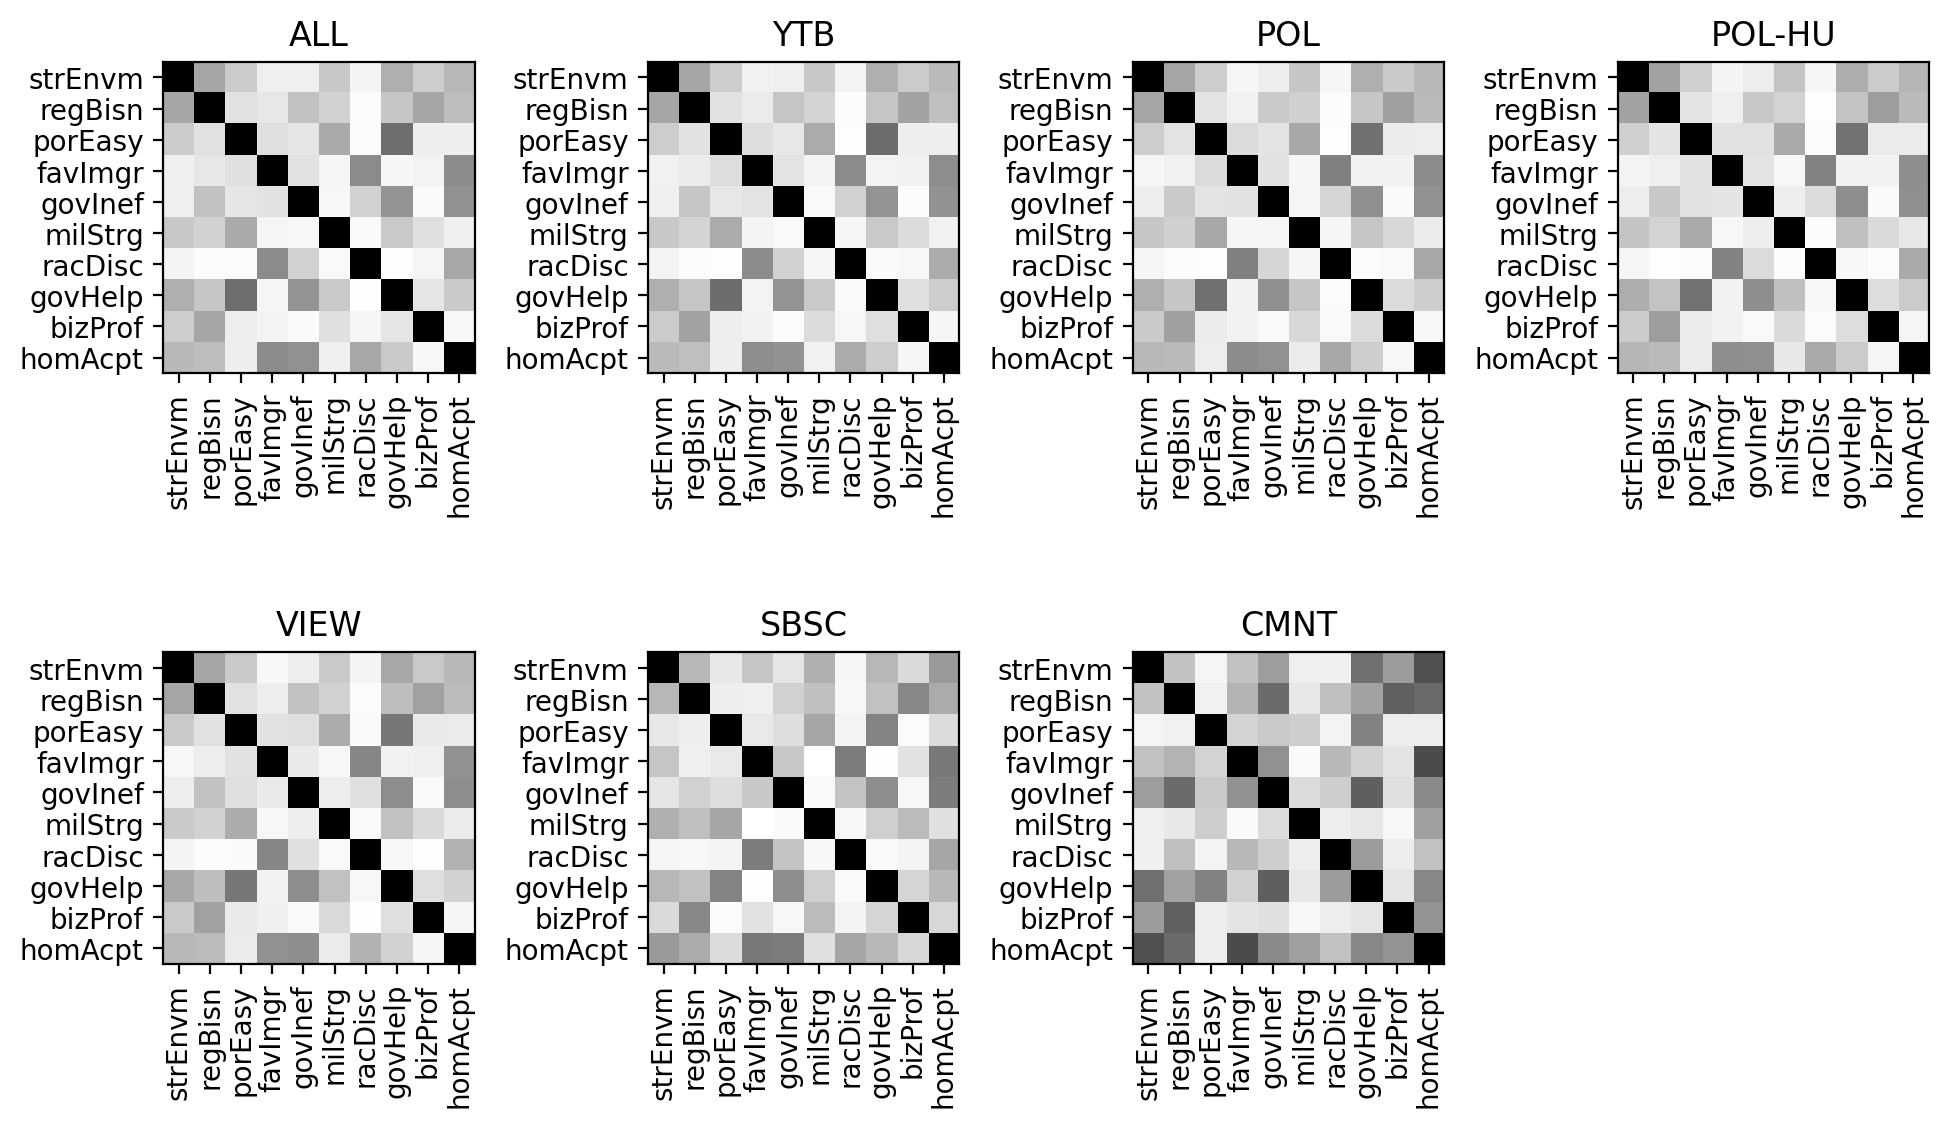

In [ ]:
issue_cols = [
    # "lftRght", "feel_thm_fdsz",
    "strEnvm", "regBisn", "porEasy", "favImgr", "govInef", 
    "milStrg","racDisc", "govHelp", "bizProf", "homAcpt"
    ]

fig,axes = plt.subplots(ncols=4, nrows=2, figsize=(10,6))
axes = [x for ls in axes for x in ls]
# varname = "lftRght"
for ax,u,lab in zip(axes, UGROUPS, UGROUPS_LAB):
    subdf = pol_df[pol_df["respondent_id"].isin(u)]
    ax.imshow(abs(subdf[issue_cols].corr()), vmin=0, vmax=.6, cmap="Greys")
    ax.set_title(lab, fontsize=12)
    ax.set_xticks(range(len(issue_cols)), issue_cols, rotation=90)
    # ax.set_xlabel(varname, fontsize=12)
    ax.set_yticks(range(len(issue_cols)), issue_cols)
plt.tight_layout()
axes[-1].set_visible(False)
# plt.savefig(OUTPATH + f"distribution-user-issue-corr-pol-activities.pdf", dpi=300, bbox_inches="tight")
# TODO: maybe implement a weighted version

In [ ]:
aggr_func1 = {"channel_id_time": lambda x: list(x)}
aggr_func2 = {"channel_id":lambda x: list(x)}
pol_view["channel_id_time"] = pol_view.apply(lambda x: (x["channel_id"], x["timestamp"]), axis=1)
view_aggr = pol_view.groupby("respondent_id").agg(aggr_func1).reset_index()
subscribe_aggr = pol_subscribe.groupby("respondent_id").agg(aggr_func2).reset_index()
comment_aggr = pol_comment.groupby("respondent_id").agg(aggr_func2).reset_index()

In [ ]:
def get_channel_label(channel_id, label_map, before_after=""):
    if before_after == "":
        return label_map[channel_id]
    else:
        return label_map[channel_id][before_after]

def assign_score_engagement(channel_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def assign_score_engagement_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP):
    num = 0
    den = 0
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    num += get_channel_label(c, label_map=label_map, before_after="before")
                else:
                    num += get_channel_label(c, label_map=label_map, before_after="after")
            else:
                num += get_channel_label(c, label_map=label_map)
            den += 1
    if den == 0:
        return np.NaN 
    else:
        return num/den

def compute_stats_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    ls.append(get_channel_label(c, label_map=label_map, before_after="before"))
                else:
                    ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))

    dsp = func(ls)
    return dsp

def compute_stats(channel_ls, label_map=CHANNEL_LABEL_MAP, func=compute_kurtosis):
    ls = []
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                ls.append(get_channel_label(c, label_map=label_map, before_after="after"))
            else:
                ls.append(get_channel_label(c, label_map=label_map))
    dsp = func(ls)
    return dsp

In [ ]:
view_aggr["view_score"] = view_aggr["channel_id_time"].map(lambda x: assign_score_engagement_temporal(x))
subscribe_aggr["subscribe_score"] = subscribe_aggr["channel_id"].map(lambda x: assign_score_engagement(x))
comment_aggr["comment_score"] = comment_aggr["channel_id"].map(lambda x: assign_score_engagement(x))

print("# of users to compare:")
print("view:", len(view_aggr))
print("subscribe:", len(subscribe_aggr))
print("comment:", len(comment_aggr))

# of users to compare:
view: 665
subscribe: 428
comment: 112


In [ ]:
view_aggr["view_var"] = view_aggr["channel_id_time"].map(lambda x: compute_stats_temporal(x, func=compute_variance))
subscribe_aggr["subscribe_var"] = subscribe_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))
comment_aggr["comment_var"] = comment_aggr["channel_id"].map(lambda x: compute_stats(x, func=compute_variance))

In [ ]:
# sample1 = [x for x in view_aggr["view_score"].tolist() if str(x)!="nan"]
# sample2 = [x for x in subscribe_aggr["subscribe_score"].tolist() if str(x)!="nan"]
# sample3 = [x for x in comment_aggr["comment_score"].tolist() if str(x)!="nan"]

sample1 = [x for x in view_aggr["view_var"].tolist() if str(x)!="nan"]
sample2 = [x for x in subscribe_aggr["subscribe_var"].tolist() if str(x)!="nan"]
sample3 = [x for x in comment_aggr["comment_var"].tolist() if str(x)!="nan"]

In [ ]:
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, get_p, normalize
from src.utils.functions import compare_distribution_with_sig_weighted

sample_dict = {"VIEW": sample1, "SBSC": sample2, "CMNT": sample3}

groups = [("VIEW", "SBSC"), ("VIEW", "CMNT"), ("SBSC", "CMNT")]

for g1, g2 in groups:
    s1 = sample_dict[g1]
    s2 = sample_dict[g2]
    print(g1, "size =", len(s1), g2, "size =", len(s2))
    p1, p2 = compare_distribution_with_sig(
        s1, 
        s2,
        sample_size=min(len(s1),len(s2)),
        test_func=ks_2samp, 
        bruns=1000)
    print("p1 =", round(p1, 5), "p2 =", round(p2, 5))
    

VIEW size = 640 SBSC size = 299
N1 = 299 	N2 = 299
p1 = 0.0 p2 = 0.0
VIEW size = 640 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0
SBSC size = 299 CMNT size = 72
N1 = 72 	N2 = 72
p1 = 0.0 p2 = 0.0


In [ ]:
np.mean(comment_aggr["comment_score"])
# np.mean(subscribe_aggr["subscribe_score"])

-0.37374638822303097

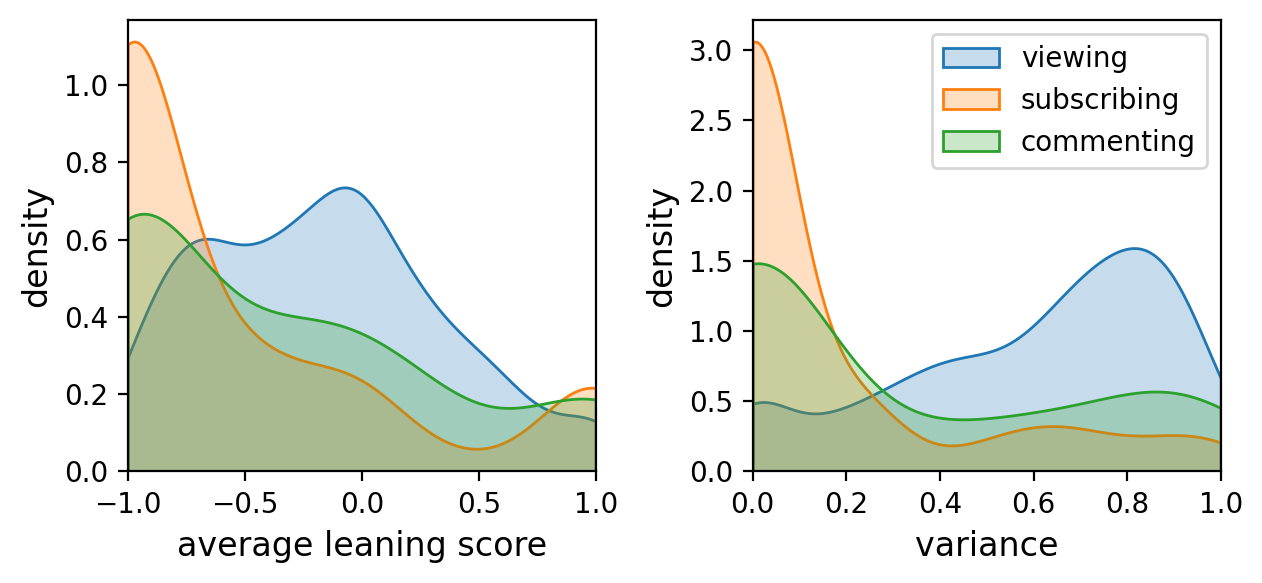

In [25]:
import seaborn as sns
fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
sns.kdeplot(view_aggr["view_score"], label="viewing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_score"], label="subsribing", fill=True, ax=axes[0], cut=0)
sns.kdeplot(comment_aggr["comment_score"], label="commenting", fill=True, ax=axes[0], cut=0)

axes[0].set_xlim(-1, 1)
axes[0].set_xlabel("average leaning score", fontsize=12)
axes[0].set_ylabel("density", fontsize=12)
axes[1].set_ylabel("density", fontsize=12)
# axes[0].legend()

sns.kdeplot(view_aggr["view_var"], label="viewing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(subscribe_aggr["subscribe_var"], label="subscribing", fill=True, ax=axes[1], cut=0)
sns.kdeplot(comment_aggr["comment_var"], label="commenting", fill=True, ax=axes[1], cut=0)
axes[1].set_xlabel("variance", fontsize=12)
axes[1].set_xlim(0, 1)
axes[1].legend()
plt.tight_layout()
plt.savefig(OUTPATH + "engage-avg-leaning-var.pdf", dpi=300, bbox_inches="tight")

In [62]:
USER_ANTIPRO_MAP = pol_df[["respondent_id","feel_thm_fdsz"]].set_index("respondent_id").to_dict()["feel_thm_fdsz"]
view_aggr["apgov"] = view_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
subscribe_aggr["apgov"] = subscribe_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
comment_aggr["apgov"] = comment_aggr["respondent_id"].map(lambda x: USER_ANTIPRO_MAP[x])
view_aggr["label"] = "view"
subscribe_aggr["label"] = "subscribe"
comment_aggr["label"] = "comment"
cols = ["respondent_id", "apgov", "label"]
all_aggr = pd.concat([
    view_aggr[cols + ["view_score"]].rename(columns={"view_score":"score"}),
    subscribe_aggr[cols + ["subscribe_score"]].rename(columns={"subscribe_score":"score"}),
    comment_aggr[cols + ["comment_score"]].rename(columns={"comment_score":"score"}),
])
all_aggr

,respondent_id,apgov,label,score
0,20145,0.0,view,0.000000
1,20377,6.0,view,-0.250000
2,21712,10.0,view,-0.340426
3,23815,4.0,view,-0.089147
4,26713,0.0,view,-0.476190
...,...,...,...,...
107,1262637,8.0,comment,-1.000000
108,1262676,NaN,comment,-0.733333
109,1265589,8.0,comment,NaN
110,1265730,6.0,comment,-1.000000


0.3435270660011407 4.0292554338075516e-17
0.38754514906007725 2.7476589997971683e-11
0.1779105628472296 0.14359503436015747


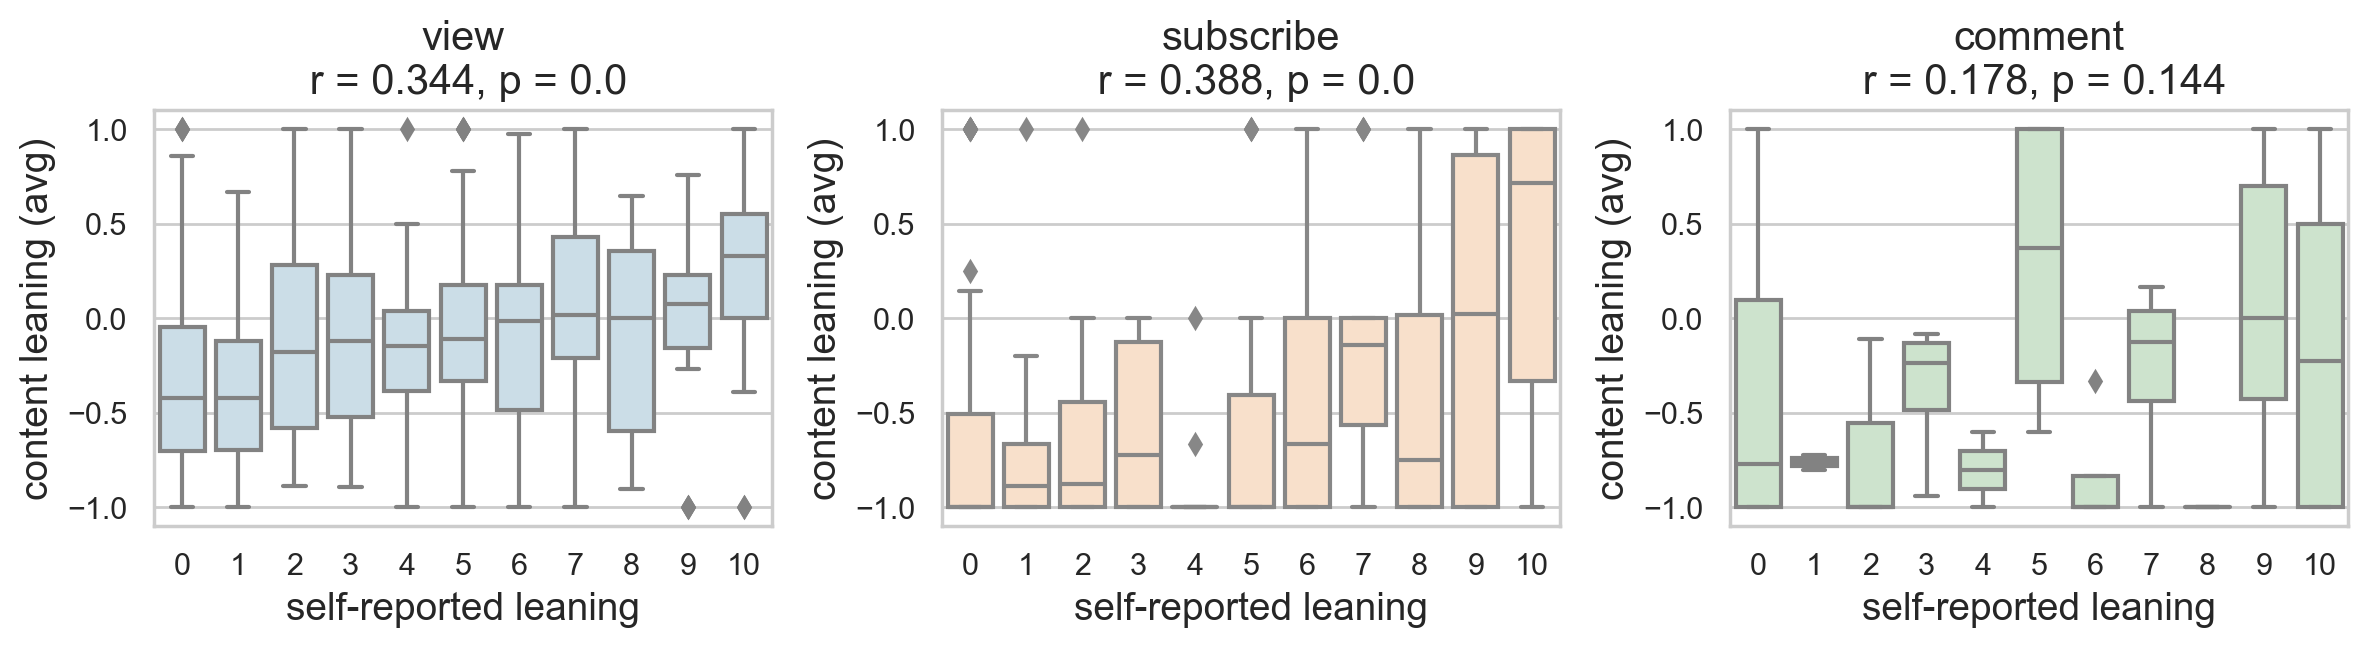

In [93]:
from scipy.stats import mstats
fig,axes = plt.subplots(figsize=(12,3.4), ncols=3)
colors = ["#C6DEEC", "#FFDFC3", "#CAE7C9"]
labels = ["view", "subscribe", "comment"]
sns.set(style="whitegrid")
for i, (ax,lab) in enumerate(zip(axes, labels)):
    sub_aggr = all_aggr[all_aggr["label"]==lab].dropna()
    r,p = mstats.pearsonr(sub_aggr["score"], sub_aggr["apgov"])
    print(r,p)
    # sns.violinplot(x="apgov", y="score", data = sub_aggr, color=colors[i], ax=ax)
    sns.boxplot(x="apgov", y="score", data = sub_aggr, color=colors[i], ax=ax)
    ax.set_ylabel("content leaning (avg)", fontsize=14)
    ax.set_xlabel("self-reported leaning", fontsize=14)
    ax.set_title(lab + f"\n r = {round(r,3)}, p = {round(p,3)}", fontsize=15)
    # ax.set_ylim(-1,1)
    ax.set_xticks(range(0,11), range(0,11))

plt.tight_layout()
plt.savefig(OUTPATH + "corr_leaning_content_survey.png", dpi=300)



In [48]:
view_bp_data = []
subscribe_bp_data = []
comment_bp_data = []
for i in range(1,11):
    view_bp_data.append([x for x in view_aggr[view_aggr["apgov"]==i]["view_score"].tolist() if str(x)!="nan"])
    subscribe_bp_data.append([x for x in subscribe_aggr[subscribe_aggr["apgov"]==i]["subscribe_score"].tolist() if str(x)!="nan"])
    comment_bp_data.append([x for x in comment_aggr[comment_aggr["apgov"]==i]["comment_score"].tolist() if str(x)!="nan"])

In [ ]:
# checking histogram visualization
# import seaborn as sns
# fig,axes = plt.subplots(figsize=(6.4,3), ncols=2)
# # sns.kdeplot(view_aggr["view_score"], label="viewing", fill=True, ax=axes[0])
# # sns.kdeplot(subscribe_aggr["subscribe_score"], label="subsribing", fill=True, ax=axes[0])
# # sns.kdeplot(comment_aggr["comment_score"], label="commenting", fill=True, ax=axes[0])

# axes[0].hist(view_aggr["view_score"], label="viewing", bins=20)
# axes[0].hist(subscribe_aggr["subscribe_score"], label="subscribing", bins=20)
# axes[0].hist(comment_aggr["comment_score"], label="commenting", bins=20)

# axes[0].set_xlim(-1, 1)
# axes[0].set_xlabel("average leaning score", fontsize=12)
# axes[0].set_ylabel("density", fontsize=12)
# # axes[0].legend()

# axes[1].hist(view_aggr["view_var"], label="viewing", bins=20)
# axes[1].hist(subscribe_aggr["subscribe_var"], label="subscribing", bins=20)
# axes[1].hist(comment_aggr["comment_var"], label="commenting", bins=20)
# axes[1].set_xlabel("variance", fontsize=12)
# axes[1].legend()
# plt.tight_layout()
# # plt.savefig(OUTPATH + "engage-avg-leaning-var.pdf", dpi=300, bbox_inches="tight")